# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [57]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [58]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [59]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [60]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


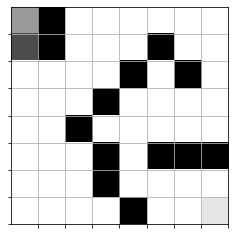

In [61]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [62]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [63]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [93]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [127]:
# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
   
   # Defining hyperparameters
    state_size = qmaze.maze.size  # Size of the state space
    action_size = 4  # Number of possible actions the agent can take (LEFT, UP, RIGHT, DOWN)
    learning_rate = 0.001  # Learning rate for the optimizer
    gamma = 0.99  # Discount factor for future rewards
    epsilon_start = 1.0  # Initial exploration rate (epsilon)
    epsilon_end = 0.01  # Minimum exploration rate (epsilon)
    epsilon_decay = 0.995  # Decay rate for epsilon, controlling the exploration-exploitation trade-off
    replay_buffer_size = 10000  # Maximum size of the replay memory
    batch_size = 64  # Number of experiences to sample from the replay memory for each training step
    target_update_freq = 100  # Frequency of updating the target network (in episodes)
    num_episodes = 1000  # Total number of episodes for training
    max_steps = 100  # Maximum steps per episode

    # Initialize the Q-network and target Q-network
    q_network = QNetwork(state_size, action_size)
    target_q_network = QNetwork(state_size, action_size)
    target_q_network.load_state_dict(q_network.state_dict())
    target_q_network.eval()

    # Define optimizer and loss function
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Function to select an action based on epsilon-greedy policy
    def get_action(state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = q_network(state)
                return np.argmax(q_values.numpy())
        else:
            return random.choice([0, 1, 2, 3])

    # Main training loop
    epsilon = epsilon_start
    all_rewards = []

    for ep in range(num_episodes):  # Renamed to `ep` to avoid conflict
        # Randomly select a free cell
        agent_cell = random.choice(qmaze.free_cells)

        # Reset the maze with agent set to above position
        state = qmaze.reset(agent_cell)

        # Get initial state
        envstate = qmaze.observe()

        total_reward = 0
        for t in range(max_steps):
            # While state is not game over:
            if qmaze.game_status() == 'win' or qmaze.game_status() == 'lose':
                break

            # Store the previous state
            previous_envstate = envstate

            # Randomly choose action (left, right, up, down) either by exploration or by exploitation
            action = get_action(envstate, epsilon)

            # Take action and get new state, reward, and game status
            envstate, reward, game_status = qmaze.act(action)

            # Determine if the episode is done based on game status
            done = game_status in ['win', 'lose']

            # Store episode in experience replay
            episode = (previous_envstate, action, reward, envstate, done)  # Updated to have five values
            experience.remember(episode)

            # Train neural network model and evaluate loss
            if len(experience.memory) >= batch_size:
                batch = random.sample(experience.memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.FloatTensor(states).squeeze(1)  # Remove extra dimension
                next_states = torch.FloatTensor(next_states).squeeze(1)  # Remove extra dimension
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                dones = torch.FloatTensor(dones)

                # Debugging statements
#                 print(f"states shape: {states.shape}")
#                 print(f"actions shape: {actions.shape}")
#                 print(f"rewards shape: {rewards.shape}")
#                 print(f"next_states shape: {next_states.shape}")
#                 print(f"dones shape: {dones.shape}")

                current_q_values = q_network(states).gather(1, actions.view(-1, 1)).squeeze(1)
                next_q_values = target_q_network(next_states).max(1)[0]
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))

                loss = criterion(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_reward += reward

            if done:
                break

        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        all_rewards.append(total_reward)

        if ep % target_update_freq == 0:
            target_q_network.load_state_dict(q_network.state_dict())

        print(f'Episode {ep}/{num_episodes}, Total Reward: {total_reward}')

    # Plotting the rewards
    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()
    
     # This is a small utility for printing readable time strings:
    def format_time(seconds):
        if seconds < 400:
            s = float(seconds)
            return "%.1f seconds" % (s,)
        elif seconds < 4000:
            m = seconds / 60.0
            return "%.2f minutes" % (m,)
        else:
            h = seconds / 3600.0
            return "%.2f hours" % (h,)


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
    dt = datetime.datetime.now() - start_time
    t = format_time(dt.total_seconds())
    template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
    print(template.format(ep, n_epoch-1, loss, num_episodes, sum(win_history), win_rate, t))
    # Checking if training has exhausted all free cells and if in all
    # cases the agent won.
    if win_rate > 0.9 : 
        epsilon = 0.05
    if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
        print("Reached 100%% win rate at epoch: %d" % (epoch,))
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (ep, max_memory, data_size, t))
    return seconds

   

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

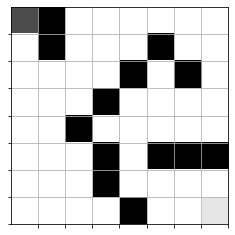

In [128]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

Episode 0/1000, Total Reward: -7.609999999999999
Episode 1/1000, Total Reward: -23.11
Episode 2/1000, Total Reward: -18.099999999999994
Episode 3/1000, Total Reward: -21.009999999999998
Episode 4/1000, Total Reward: -22.269999999999996
Episode 5/1000, Total Reward: -21.639999999999993
Episode 6/1000, Total Reward: -22.059999999999995
Episode 7/1000, Total Reward: -21.219999999999995
Episode 8/1000, Total Reward: -22.479999999999997
Episode 9/1000, Total Reward: 1.0
Episode 10/1000, Total Reward: -22.06
Episode 11/1000, Total Reward: -22.689999999999998
Episode 12/1000, Total Reward: -21.639999999999997
Episode 13/1000, Total Reward: -21.639999999999997
Episode 14/1000, Total Reward: -21.849999999999998
Episode 15/1000, Total Reward: -22.689999999999998
Episode 16/1000, Total Reward: -20.799999999999994
Episode 17/1000, Total Reward: -22.9
Episode 18/1000, Total Reward: -20.58999999999999
Episode 19/1000, Total Reward: -21.639999999999993
Episode 20/1000, Total Reward: -21.8499999999999

Episode 171/1000, Total Reward: -19.329999999999984
Episode 172/1000, Total Reward: -20.169999999999995
Episode 173/1000, Total Reward: 0.96
Episode 174/1000, Total Reward: -3.8400000000000007
Episode 175/1000, Total Reward: -1.2400000000000002
Episode 176/1000, Total Reward: -12.039999999999996
Episode 177/1000, Total Reward: 0.96
Episode 178/1000, Total Reward: -4.290000000000001
Episode 179/1000, Total Reward: -1.4900000000000002
Episode 180/1000, Total Reward: -2.0500000000000007
Episode 181/1000, Total Reward: -4.000000000000001
Episode 182/1000, Total Reward: -4.62
Episode 183/1000, Total Reward: -3.380000000000001
Episode 184/1000, Total Reward: 0.6300000000000001
Episode 185/1000, Total Reward: 1.0
Episode 186/1000, Total Reward: 1.0
Episode 187/1000, Total Reward: -5.840000000000001
Episode 188/1000, Total Reward: 0.75
Episode 189/1000, Total Reward: -6.430000000000001
Episode 190/1000, Total Reward: -3.210000000000001
Episode 191/1000, Total Reward: 0.96
Episode 192/1000, Tot

Episode 342/1000, Total Reward: 0.51
Episode 343/1000, Total Reward: 0.84
Episode 344/1000, Total Reward: -1.290000000000001
Episode 345/1000, Total Reward: -0.7100000000000004
Episode 346/1000, Total Reward: 0.72
Episode 347/1000, Total Reward: -2.220446049250313e-16
Episode 348/1000, Total Reward: -0.17000000000000015
Episode 349/1000, Total Reward: -1.2500000000000004
Episode 350/1000, Total Reward: -0.4700000000000004
Episode 351/1000, Total Reward: -0.020000000000000018
Episode 352/1000, Total Reward: 0.96
Episode 353/1000, Total Reward: -0.9300000000000002
Episode 354/1000, Total Reward: -0.050000000000000266
Episode 355/1000, Total Reward: 0.22999999999999998
Episode 356/1000, Total Reward: 0.39
Episode 357/1000, Total Reward: 0.4700000000000001
Episode 358/1000, Total Reward: -1.3800000000000008
Episode 359/1000, Total Reward: 0.3899999999999999
Episode 360/1000, Total Reward: -2.370000000000001
Episode 361/1000, Total Reward: 0.16999999999999993
Episode 362/1000, Total Reward:

Episode 512/1000, Total Reward: 0.72
Episode 513/1000, Total Reward: -11.359999999999985
Episode 514/1000, Total Reward: 1.0
Episode 515/1000, Total Reward: -2.700000000000001
Episode 516/1000, Total Reward: -3.170000000000001
Episode 517/1000, Total Reward: -0.2200000000000002
Episode 518/1000, Total Reward: -0.30000000000000027
Episode 519/1000, Total Reward: 0.31999999999999995
Episode 520/1000, Total Reward: -1.0400000000000005
Episode 521/1000, Total Reward: -0.7100000000000004
Episode 522/1000, Total Reward: -2.0800000000000005
Episode 523/1000, Total Reward: -0.30000000000000027
Episode 524/1000, Total Reward: 0.21999999999999997
Episode 525/1000, Total Reward: 0.0399999999999997
Episode 526/1000, Total Reward: 0.6000000000000001
Episode 527/1000, Total Reward: 0.23999999999999988
Episode 528/1000, Total Reward: 0.0399999999999997
Episode 529/1000, Total Reward: -0.6200000000000006
Episode 530/1000, Total Reward: 0.22999999999999998
Episode 531/1000, Total Reward: -0.79000000000

Episode 684/1000, Total Reward: -2.220446049250313e-16
Episode 685/1000, Total Reward: 0.6799999999999999
Episode 686/1000, Total Reward: 1.0
Episode 687/1000, Total Reward: 0.19999999999999984
Episode 688/1000, Total Reward: 0.84
Episode 689/1000, Total Reward: -0.22000000000000064
Episode 690/1000, Total Reward: 0.2799999999999999
Episode 691/1000, Total Reward: 0.4
Episode 692/1000, Total Reward: 0.07999999999999974
Episode 693/1000, Total Reward: 0.4800000000000001
Episode 694/1000, Total Reward: -1.4200000000000008
Episode 695/1000, Total Reward: 0.56
Episode 696/1000, Total Reward: 0.6799999999999999
Episode 697/1000, Total Reward: 0.84
Episode 698/1000, Total Reward: 0.36
Episode 699/1000, Total Reward: -0.0800000000000003
Episode 700/1000, Total Reward: 0.6799999999999999
Episode 701/1000, Total Reward: -21.22
Episode 702/1000, Total Reward: -2.15
Episode 703/1000, Total Reward: 0.21999999999999997
Episode 704/1000, Total Reward: 0.76
Episode 705/1000, Total Reward: -22.27
Epis

Episode 857/1000, Total Reward: 1.0
Episode 858/1000, Total Reward: -0.7500000000000004
Episode 859/1000, Total Reward: -0.05000000000000049
Episode 860/1000, Total Reward: 0.6000000000000001
Episode 861/1000, Total Reward: -0.010000000000000231
Episode 862/1000, Total Reward: 0.19999999999999984
Episode 863/1000, Total Reward: -0.6700000000000006
Episode 864/1000, Total Reward: -1.3800000000000003
Episode 865/1000, Total Reward: 0.6000000000000001
Episode 866/1000, Total Reward: -2.220446049250313e-16
Episode 867/1000, Total Reward: 0.96
Episode 868/1000, Total Reward: -2.220446049250313e-16
Episode 869/1000, Total Reward: 0.6799999999999999
Episode 870/1000, Total Reward: 0.8
Episode 871/1000, Total Reward: 0.6799999999999999
Episode 872/1000, Total Reward: 0.72
Episode 873/1000, Total Reward: 0.8
Episode 874/1000, Total Reward: -0.5800000000000005
Episode 875/1000, Total Reward: 0.64
Episode 876/1000, Total Reward: 0.56
Episode 877/1000, Total Reward: 0.18999999999999995
Episode 878

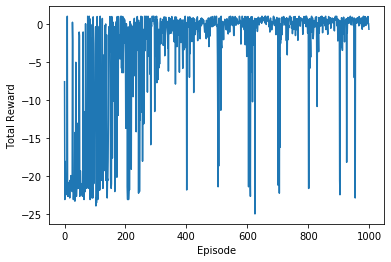

Epoch: 999/14999 | Loss: 0.0013 | Episodes: 1000 | Win count: 0 | Win rate: 0.000 | time: 7.34 minutes
n_epoch: 999, max_mem: 512, data: 32, time: 7.34 minutes


440.20538

In [131]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

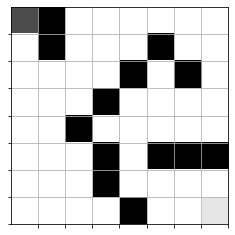

In [130]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

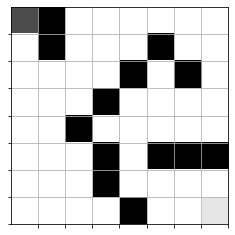

In [129]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.